<h1><center>CMPE 462 - PS1 <br> Linear Regression with numpy and matplotlib</center></h1>

This notebook provides a closed-form implementation of linear regression with regularization using `numpy` using an artificial data set. We provide visualizations using `matplotlib` as well. We hope that this notebook introduces `numpy` and `matplotlib` properly and exemplifies a neat notebook organization for project submissions.

## Table of Contents

* [Data Set Creation](#dataset_creation)
* [Data Set Visualization](#dataset_vis)
* [Linear Regression](#linear_regression)
* [Evaluation](#evaluation)
* [Regularization](#regularization)
* [Conclusion](#Conclusion)
* [Appendix](#appendix)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

<a id='dataset_creation'></a>
### Data Set Creation

Let us first create a data set that we will perform the regression on. Our data set consists of randomly created training and test features. We calculate the corresponding labels by assuming that we know the underlying function we seek using linear regression. 

The training and test matrices are $N\times 2$ (1 feature and intercept) for visualization purposes but the codes and concepts in this notebook are valid for higher dimensions as well.

In [2]:
def create_dataset(sample_size, n_features, rng, shift, weights, eps_coeff):
    X = rng * np.random.rand(sample_size, n_features) + shift
    X_intercept = np.hstack([X, np.ones((sample_size, 1))])
    eps = eps_coeff * np.random.randn(sample_size, 1)
    y = X_intercept @ weights + eps
    
    return X_intercept, y

In [3]:
sample_size, n_features = 1000, 1
rng, shift = 10, -5
w0, w1 = 5, 10
weights = np.array([[w0], [w1]])
eps_coeff = 5

In [4]:
X_train, y_train = create_dataset(sample_size, n_features, rng, shift, weights, eps_coeff)
X_test, y_test = create_dataset(sample_size // 4, n_features, rng, shift, weights, eps_coeff)

np.hstack([X_train[:10, :], y_train[:10, :]])

array([[ -0.82977995,   1.        ,   9.47885283],
       [  2.20324493,   1.        ,  19.39520357],
       [ -4.99885625,   1.        , -10.92256561],
       [ -1.97667427,   1.        ,   4.01897828],
       [ -3.53244109,   1.        , -14.98247333],
       [ -4.07661405,   1.        , -11.15552623],
       [ -3.13739789,   1.        ,  -6.14915102],
       [ -1.54439273,   1.        ,   1.08866002],
       [ -1.03232526,   1.        ,   1.06005989],
       [  0.38816734,   1.        ,  21.19802617]])

<a id='dataset_vis'></a>
### Data Set Visualization

Let us visualize the training and test data separately. We use scatter plots to visualize the sampled matrices and also plot the line we have sampled.

In [5]:
def plot_X_vs_y(X, y, w0, w1, title):
    plt.figure(figsize=(15, 5))
    inputs = np.linspace(-(rng + shift), rng + shift, 2)
    plt.scatter(X[:, 0], y, label='Sampled Data', s=10)
    plt.plot(inputs, w0 * inputs + w1, color='red', label='Actual Line')
    plt.title(title)
    plt.xlabel('Feature')
    plt.ylabel('Label')
    plt.legend()
    plt.grid()
    plt.show()

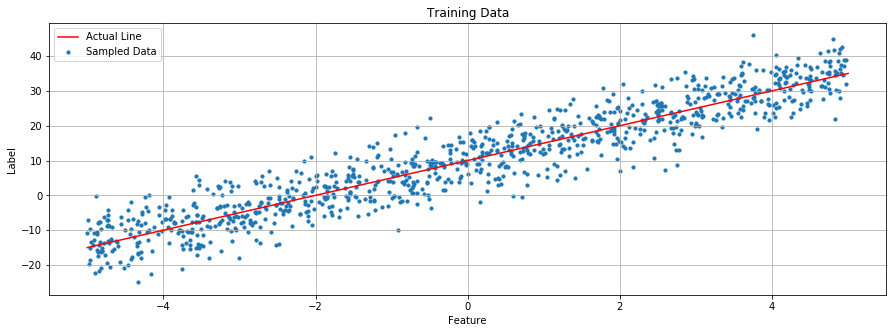

In [6]:
plot_X_vs_y(X_train, y_train, w0, w1, 'Training Data')

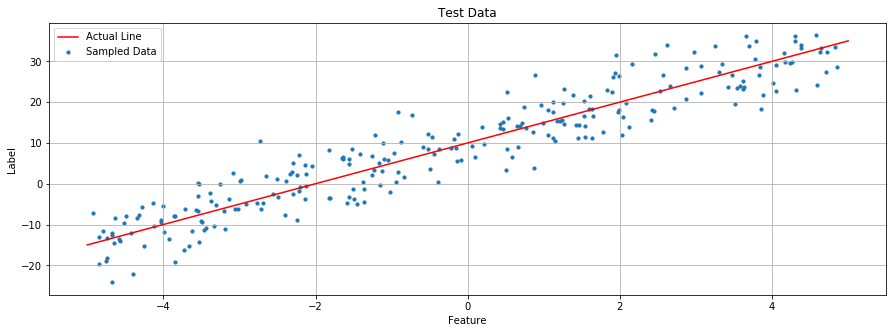

In [7]:
plot_X_vs_y(X_test, y_test, w0, w1, 'Test Data')

<a id='linear_regression'></a>
### Linear Regression

To find the weights that minimize the squared error, we use closed-form solution of linear regression. We know from the lectures that optimum weights can be obtained by the equation:

$$w^* = (X^T X)^{-1} X^T y$$

where $X$ is the design matrix and $y$ is the label vector. Here we note that if $X^T X$ is rank deficient, then the inverse cannot be computed. This is a down-side of using the closed form solution.

In [8]:
def solve_regression(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

In [9]:
w_star = solve_regression(X_train, y_train)
w0_star, w1_star = w_star[0, 0], w_star[1, 0]
w0_star, w1_star

(5.0053168637601395, 10.23657337091913)

Here we add the predicted line to the previous plot and inspect the performance visually. Though we can parameterize the previous plotting function to serve both purposes, we just copy and paste it here and modify :)

In [10]:
def plot_X_vs_y_with_solution(X, y, w0, w1, w0_star, w1_star, title):
    plt.figure(figsize=(15, 5))
    inputs = np.linspace(-(rng + shift), (rng + shift), 2)
    plt.scatter(X[:, 0], y, label='Sampled Data', s=10)
    plt.plot(inputs, w0 * inputs + w1, color='red', label='Actual Line')
    plt.plot(inputs, w0_star * inputs + w1_star, color='purple', label='Predicted Line')
    plt.title(title)
    plt.xlabel('Feature')
    plt.ylabel('Label')
    plt.legend()
    plt.grid()
    plt.show()

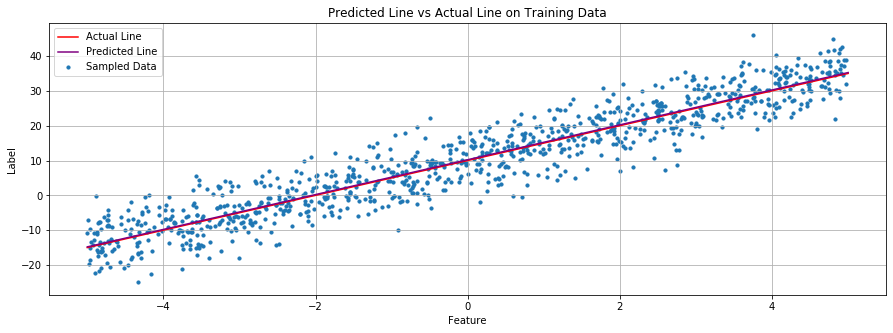

In [11]:
plot_X_vs_y_with_solution(X_train, y_train, w0, w1, w0_star, w1_star, 'Predicted Line vs Actual Line on Training Data')

<a id='evaluation'></a>
### Evaluation

Visual inspection is helpful to derive insights but more often than not we need a numeric measure of success. Thus, we compute root mean squared error ($RMSE$) of the predicted solution on the training and test data as follows:

$$\hat{y} = X w^*$$
$$ RMSE = \sqrt{\frac{1}{N} \sum_i^{N} (\hat{y}_i - y_i)^2}$$

where $N$ is the number of samples.

**Note:** Despite $RMSE$ has some downsides such as being a scale-dependent metric, it is frequently used to evaluate and compare regression models. In real-life problems, more often than not there is not a **golden** metric anyway and it makes more sense to use multiple metrics rather than one. Yet, we will stick to $RMSE$ in this notebook for simplicity.

In [12]:
def predict(X, w_star):
    return X @ w_star

def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

In [13]:
training_error = root_mean_squared_error(y_train, predict(X_train, w_star))
test_error = root_mean_squared_error(y_test, predict(X_test, w_star))

f'Training error: {training_error}, Test error: {test_error}'

'Training error: 5.091553301392811, Test error: 4.855011798538114'

<a id='regularization'></a>
### Regularization

We use regularization to control overfitting of the models. To add regularization to linear regression, we refer to lecture notes and use the following equation:

$$w^* = (X^T X + \lambda I)^{-1} X^T y$$

where $\lambda$ is the regularization coefficient. Note that this has a positive side-effect of resolving the rank deficiency issue of $X^T X$ as you have proven in Linear Algebra Assessment! (See [Appendix](#appendix) for more detail)

We expect regularization to improve test performance though it might cause a drop in training performance. On the other hand, regularization is not a magical tool to improve model performance no matter what. At times when the model itself is insufficient to capture the patterns in the training data (underfitting), regularization would decrease the model performance even further. Therefore, we should compare different model and regularization combinations with cross-validation to find the optimum.

In [14]:
def solve_regularized_regression(X, y, lambda_):
    n_cols = X.shape[1]
    return np.linalg.inv(X.T @ X + lambda_ * np.identity(n_cols)) @ X.T @ y

In [15]:
w_star_reg = solve_regularized_regression(X_train, y_train, lambda_=10 ** -1)
w0_star_reg, w1_star_reg = w_star_reg[0, 0], w_star_reg[1, 0]
w0_star_reg, w1_star_reg

(5.005257412045717, 10.23555017534634)

In [16]:
training_error_reg = root_mean_squared_error(y_train, predict(X_train, w_star_reg))
test_error_reg = root_mean_squared_error(y_test, predict(X_test, w_star_reg))

f'Training error: {training_error_reg}, Test error: {test_error_reg}, {test_error_reg < test_error}'

'Training error: 5.091553407161523, Test error: 4.85496640664309, True'

Here we run an experiment to find how many times regularization improves test performance. We generate 100 data sets and experiment with 10 $\lambda$ values for each one. If any of the $\lambda$s improves test set $RMSE$ we decide that regularization helped the linear regression for this data set.

A more robust experimental setup would be using cross-validation but we leave its implementation to reader as part of Project 1 :)

In [17]:
success = 0
for _ in range(100):
    sample_size, n_features = 10000, 1
    rng, shift = 10, -5
    weights = np.random.randn(n_features + 1, 1)
    eps_coeff = 5

    X_train, y_train = create_dataset(sample_size, n_features, rng, shift, weights, eps_coeff)
    X_test, y_test = create_dataset(sample_size // 4, n_features, rng, shift, weights, eps_coeff)

    for lambda_ in range(-5, 5):
        w_star = solve_regularized_regression(X_train, y_train, lambda_=0)
        w_star_reg = solve_regularized_regression(X_train, y_train, lambda_=10 ** lambda_)
        test_error = root_mean_squared_error(y_test, predict(X_test, w_star))
        test_error_reg = root_mean_squared_error(y_test, predict(X_test, w_star_reg))
        if test_error_reg < test_error:
            success = success + 1
            break

f'Regularization improved test performance for {success} data sets among 100'

'Regularization improved test performance for 55 data sets among 100'

<a id='conclusion'></a>

### Conclusion

In this notebook, we provided a linear regression implementation with regularization using `numpy`. We observed that regularization might or might not improve model performance, depending on the data set. We used `matplotlib` to visualize the data set and the solution. The data set we used contained only 1 feature to enable the visualizations. **However, we emphasize that the codes and concepts in this notebook are still valid for higher dimensions**. In other words, we can use the same steps to fit a line in higher dimensional spaces by increasing the input data set dimension only. We encourage you to experiment with the sample size, number of dimensions, noise, weights, and any other parameter to grasp the linear regression further. Here is an example in a 10-dimensional space.

In [18]:
sample_size, n_features = 1000, 10
weights = np.random.rand(n_features + 1, 1)

X_train_10, y_train_10 = create_dataset(sample_size, n_features, rng, shift, weights, eps_coeff)
X_test_10, y_test_10 = create_dataset(sample_size // 4, n_features, rng, shift, weights, eps_coeff)

solution_10 = solve_regression(X_train_10, y_train_10)
print(weights.T, '\n',solution_10.T)
f'Test error: {root_mean_squared_error(y_test_10, predict(X_test_10, solution_10))}'

[[0.12986211 0.25931094 0.31835723 0.76435915 0.88707227 0.35622926
  0.6638569  0.28816078 0.74745049 0.75901849 0.91801471]] 
 [[0.18176755 0.22621888 0.33083432 0.72761159 0.92541018 0.33064786
  0.69858933 0.24429858 0.76744406 0.63648758 0.75910546]]


'Test error: 4.8558920277096655'

<a id='appendix'></a>
### Appendix

Here we prove that regularization resolves the rank deficiency issue of $X^TX$. We first show that $X^TX$ is a positive semi-definite matrix, which means that its eigenvalues are non-negative. Second, we show that $X^TX + \lambda I$ $(\lambda > 0)$ has only positive eigenvalues, which means that it is full rank and invertible.

A matrix $M \in \mathbb{R}^{n \times n}$ is positive semi-definite if and only if $v^TMv \geq 0, \forall v \in \mathbb{R}^n$. We replace $M$ with $X^TX$ and write $v^T (X^TX) v$. We equivalently can write $(v^TX^T)(Xv) = || vX ||_2$ Since an $l_2$ norm is guaranteed to satisfy the $\geq 0$ condition, $X^TX$ is a positive semi-definite matrix. Therefore,  its eigenvalues are non-negative.

Now let us pick any eigenvalue $\lambda^{'}$ of $X^TX + \lambda I$ and corresponding eigenvector $v$. We write the eigenvalue equation as $(X^TX + \lambda I)v = \lambda^{'}v$. We can equivalently write $(X^TX)v = \lambda^{'}v - \lambda I v$. Grouping the RHS we obtain an eigenvalue equation for $X^TX$ as $(X^TX)v = (\lambda^{'} - \lambda)v$. Thus, $(\lambda^{'} - \lambda)$ is an eigenvalue for $X^TX$ and non-negative due to positive semi-definiteness of $X^{T}X$. Since $\lambda > 0, \lambda^{'} > 0$ as well. This proves that any eigenvalue of $X^TX + \lambda I$ is positive and the matrix itself is full rank. Regularization resolved the rank deficiency issue! 

Here are the same equations in a different format:

$$
\begin{align}
    (X^TX + \lambda I)v &= \lambda^{'}v \\
    (X^TX)v &= \lambda^{'}v - \lambda I v \\
    (X^TX)v &= (\lambda^{'} - \lambda)v \\
    \lambda^{'} - \lambda &\geq 0 \\
    \lambda^{'} \geq \lambda &> 0 \\
    \lambda^{'} &> 0
\end{align}
$$

Now we show an example by code. We first create a rank deficient matrix $X$ and compute $X^TX$. We then observe that $X^TX$ is non-invertible and compute its eigenvalues. Last, we add $\lambda I$ to $X^TX$ and show that it is now invertible and has only positive eigenvalues.

In [19]:
X = np.random.rand(10, 5)
X[:, :2] = 1 # Guarantee rank-deficiency
XTX = X.T @ X
try:
    np.linalg.inv(XTX)
except np.linalg.LinAlgError:
    print('X^T X is singular and cannot be inverted!')
    print(f'Its eigenvalues are {np.linalg.eigvals(XTX)}, which are all non-negative (Ignoring numerical error)')


X^T X is singular and cannot be inverted!
Its eigenvalues are [ 2.72567455e+01 -6.02246060e-16  4.19860439e-01  7.77787889e-01
  9.35641021e-01], which are all non-negative (Ignoring numerical error)


In [20]:
L = 10 ** -5
regularized = XTX + L * np.identity(XTX.shape[0])
np.linalg.inv(regularized)
print('No problem at inverting! Thank you regularization!')
eigs = np.linalg.eigvals(regularized)
assert np.all(eigs > 0)
print(f'Its eigenvalues are {eigs}, which are all positive!')

No problem at inverting! Thank you regularization!
Its eigenvalues are [2.72567555e+01 1.00000000e-05 4.19870439e-01 7.77797889e-01
 9.35651021e-01], which are all positive!


### Reference

I was inspired by [Ali Taylan Cemgil's notebook](https://github.com/atcemgil/notes/blob/master/Regression.ipynb) while preparing this one. I recommend his GitHub repository as one of the valuable resources for ML. I also thank İlkay Ramazan Pala for his proof-checking.